<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-480 Redes Complejas-2021 </h1>
    <h3> Tarea 3</h3>
    
    </br>
    <h4>Ignacio Loayza Campos  & Camilo Núñez Fernández</h4>
    <h4>ignacio.loayza.12@sansano.usm.cl & camilo.nunezf@sansano.usm.cl<h34>
    
</center>
<hr style="height:2px;border:none"/>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw as pl
import seaborn as sns
import pylab
import glob
import imageio
import re
from copy import copy
from simulation_utils import *

SEED = 11235813
N_SIMULATIONS = 10
np.random.seed(SEED)
SEEDS = np.random.randint(low = 0, high = 10000, size = N_SIMULATIONS)

## IMPORTANTE: hay que usar una version modificada de la libreria, la cual se adjunta de el codigo final
from modularity_maximization_local.utils import get_modularity
from modularity_maximization_local import partition as slow_partition

In [2]:
#!pip install powerlaw

# Pregunta 1

Definimos la función batch que creará la partición para $B$ y $C$. Es importante notar que los arcos para la partición de $B$ dependen del valor de $p$, mientras que la partición para $C$ se obtiene de probabilidades sacadas de una distribución uniforme usada por defecto por NumPy.

In [3]:
def batch_g(init_g_er, p=0.1):
    ids_B1 = list(init_g_er.nodes)[0:99]
    ids_B2 = list(init_g_er.nodes)[99:200]

    partion_B1_B2 = nx.DiGraph()
    partion_B1_B2.add_nodes_from(init_g_er)

    for edge in init_g_er.edges():
        default_direction = np.random.choice([True, False], 1, [p, 1-p])

        if (edge[0] in ids_B1 and edge[1] in ids_B2) or (edge[1] in ids_B1 and edge[0] in ids_B2):
            if default_direction:
                partion_B1_B2.add_edge(edge[0], edge[1])
            else:
                partion_B1_B2.add_edge(edge[1], edge[0])


    ids_C1 = list(init_g_er.nodes)[0:149]
    ids_C2 = list(init_g_er.nodes)[49:200]

    partion_C1_C2 = nx.DiGraph()
    partion_C1_C2.add_nodes_from(init_g_er)

    for edge in init_g_er.edges():
        default_direction = np.random.choice([True, False], 1)

        if (edge[0] in ids_C1 and edge[1] in ids_C2) or (edge[1] in ids_C1 and edge[0] in ids_C2):
            if default_direction:
                partion_C1_C2.add_edge(edge[0], edge[1])
            else:
                partion_C1_C2.add_edge(edge[1], edge[0])

    return partion_B1_B2,partion_C1_C2

Ahora inicialamos un grafo ER con 200 nodos y con $p=0.2$:

In [4]:
init_g_er = nx.erdos_renyi_graph(200, 0.2)

A continuación realizamos 100 repeticiones para obtener un promedio de las modularidades para las particiones de $B$ y $C$, utilizando la implmentacion de _(E. A. Leicht and M. E. J. Newman, 2008)_ proporcionada en la libreria modificada local:

In [5]:
%%time
def loopTestB(p):
    g_B1_B2, _= batch_g(init_g_er,p)
    #return leicht_newman_modularity(g_B1_B2)
    return get_modularity(g_B1_B2, slow_partition(g_B1_B2, refine=False))

def loopTestC(p):
    _, g_C1_C2= batch_g(init_g_er,p)
    #return leicht_newman_modularity(g_C1_C2)
    return get_modularity(g_C1_C2, slow_partition(g_C1_C2, refine=False))

values_b=[]
values_c=[]

for p in np.arange(0.0, 1.1, 0.1):
    values_b.append(np.mean(np.repeat(abs(loopTestB(p)),100)))
    values_c.append(np.mean(np.repeat(abs(loopTestC(p)),100)))

CPU times: user 1min 14s, sys: 84.4 ms, total: 1min 14s
Wall time: 1min 14s


Luego graficamos los 11 puntos de medición de modularidad para ambas particiones:

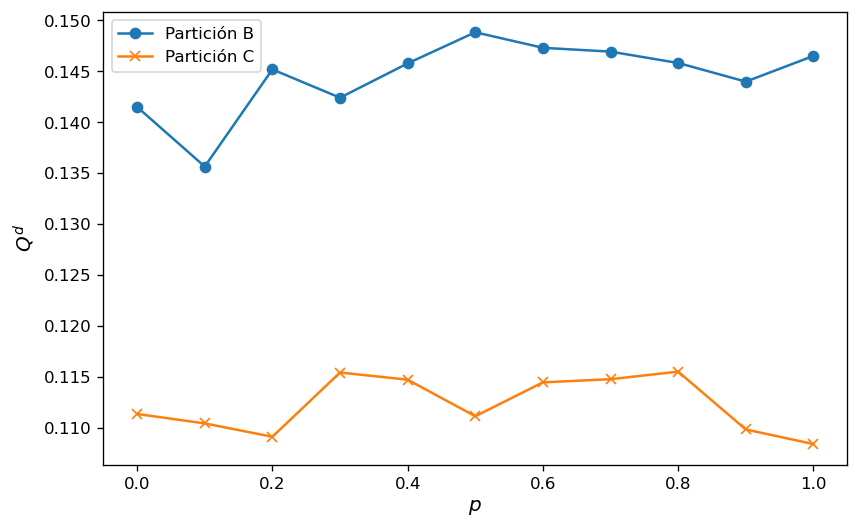

In [6]:
fig, ax = plt.subplots(figsize=(8, 5),dpi=120)

plt.plot(np.arange(0.0, 1.1, 0.1), values_b, linestyle='-', marker='o', label='Partición B')
plt.plot(np.arange(0.0, 1.1, 0.1), values_c, linestyle='-', marker='x', label='Partición C')

plt.xlabel("$p$", fontsize=12)
plt.ylabel("$Q^{d}$", fontsize=12)
plt.legend(loc='best')

plt.show()

Es interesante notar que para ambas particiones, la modularidad de la partición $B$ siempre se mantuvo mayor que la de la partición $C$, lo cual indica que, en términos del trabajo de _(E. A. Leicht and M. E. J. Newman, 2008)_ , que la partición presentan mejores ajustes de cada nodo a su respectiva comunidad (los nodos s 'fitean' mejor a la comunidad en B). Lo cual guarda relación a que las distribuciones en $B$ no son aleatorias, sino mas bien constantes en razón del valor de $p$, en cambio, para la partición de $C$, los valores de sus distribuciones de probabilidad son aleatorias en una uniforme. Sin embargo, la distancia que separa a la mínima modularidad de $C$ con la máxima modularidad de $B$ es de apenas $0.05$, lo cual indica que los valores, si bien son mayores para $B$, no son distantes ni extremadamente diferentes si se considera el conjunto completo para ambas particiones.

# Pregunta 2

## Parte 1

Comenzamos cargando la red:

In [7]:
pescado_g = nx.read_pajek("data/pescado.net")

### Sección a

Comomenzamos obteniendo los datos básicos dados por:
$$
\begin{equation}
\rho=\frac{\rho_{1}-\bar{a}}{1-\bar{a}} \quad, \text { donde } \quad \rho_{1}=\frac{1}{m} \sum_{i \neq j} a_{i, j} a_{j, i} \quad \mathrm{y} \quad \bar{a}=\frac{m}{n(n-1)}
\end{equation},
$$
de la siguiente forma:

In [8]:
m = pescado_g.number_of_edges()
n = pescado_g.number_of_nodes()

a_bar = m/n*(n-1)

W = nx.adjacency_matrix(pescado_g)

rho_1 = 0
for i in range(0,n):
    for j in range(0,n):
        if i!=j: rho_1+=(W[i,j]*W[j,i])
rho_1 = (1/m)*rho_1
            
            
rho = (rho_1-a_bar)/(1-a_bar)

Luego el valor de $\rho$ viene dado por la variable `rho`, la cual tiene el valor:

In [9]:
rho

0.5233276215408933

Luego, y en base al trabajo (Garlaschelli & Loffredo, 2008), es posible notar que la red es _recíproca_, obtiendo un valor muy simar al de la red de internet (0.5165).

### Sección b

En este caso, la métrica inventada correspode a :
$$
\begin{equation}
\rho_{w}=\frac{1}{m}\cdot \frac{\sum_{i \neq j}a_{i, j}\cdot a_{j, i}}{\sum_{i \neq j}\bar{a}}
\end{equation},
$$
la cual fue implementada de la siguiente forma:

In [10]:
rho_w = 0
for i in range(0,n):
    for j in range(0,n):
        if i!=j: 
            numerador = W[i,j] * W[j,i]
            denominador = a_bar
            rho_w+=(numerador/denominador)
rho_w = (1/m)*rho_w

Luego el valor de $\rho_w$ viene dado por la variable `rho_w`, la cual tiene el valor:

In [11]:
rho_w

0.4768643669694392

Es interesante notar que la métrica inventada no dista mucho de la utilizada anteriormente, por lo que se mantiene la reciprocidad de la red.

### Sección c

Las funciones para calcular los grados vienen dadas por:

In [12]:
s_in = lambda i: np.sum([W[j,i] for j in range(0,n)])
s_out = lambda i: np.sum([W[i,j] for j in range(0,n)])

k_in = [s_in(i) for i in range(0,n)]
k_out = [s_out(i) for i in range(0,n)]

Es importante verificar la relacion $\left\langle k^{i n}\right\rangle=\left\langle k^{o u t}\right\rangle$ para comprobar lo calculado anteriormente:

In [13]:
np.mean(k_in) == np.mean(k_out)

True

Luego, los gráficos asociados a la distrución de $P(s_{in,out})$ junto con los graficos _log-log_ son:

Values less than or equal to 0 in data. Throwing out 0 or negative values


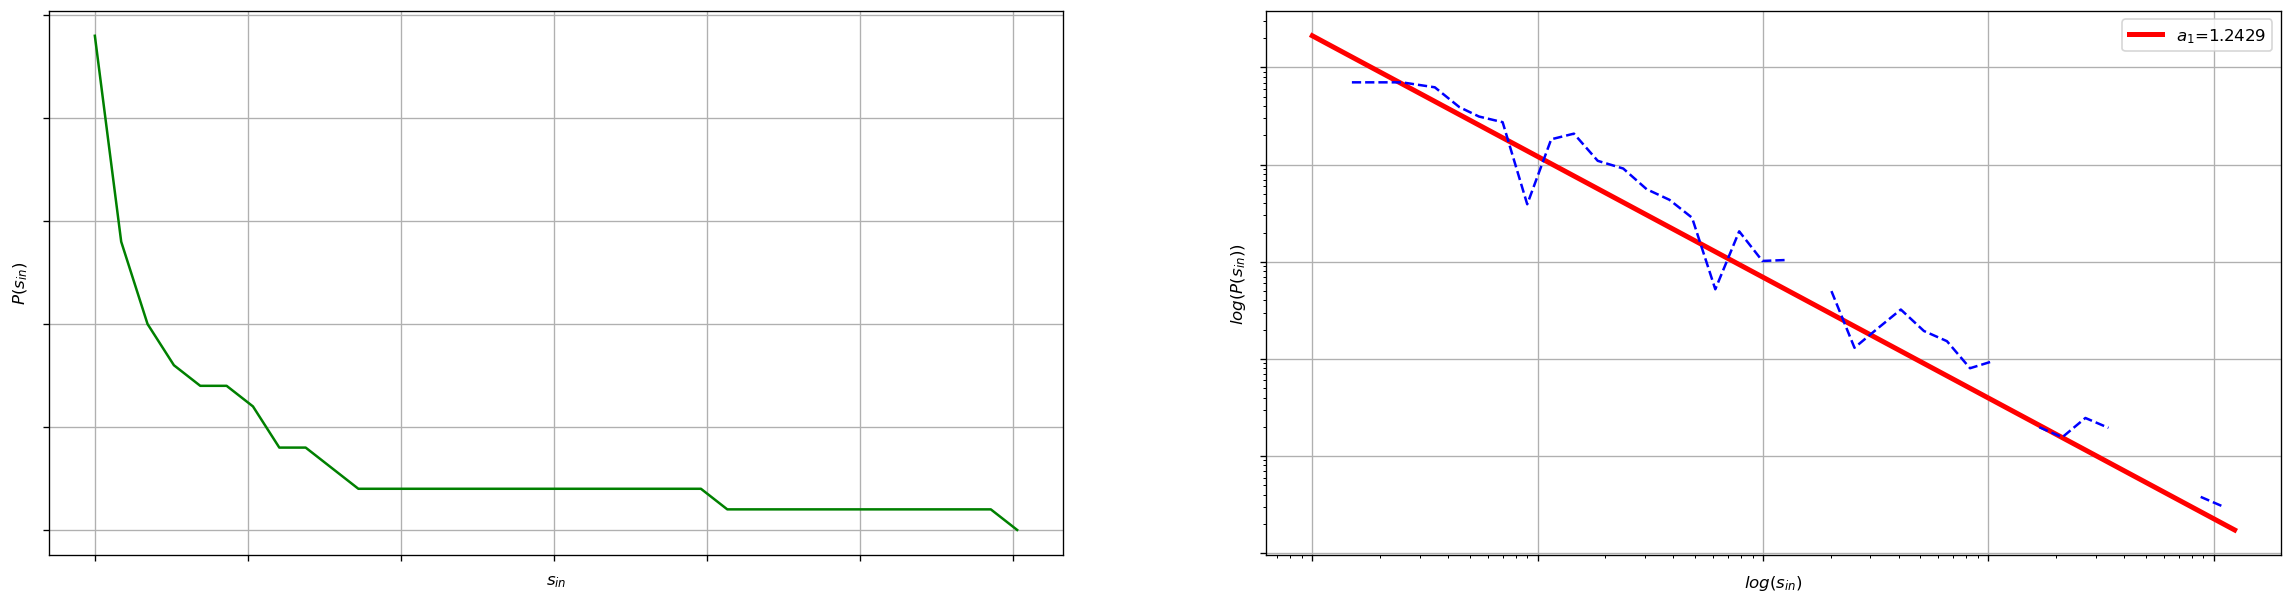

Values less than or equal to 0 in data. Throwing out 0 or negative values


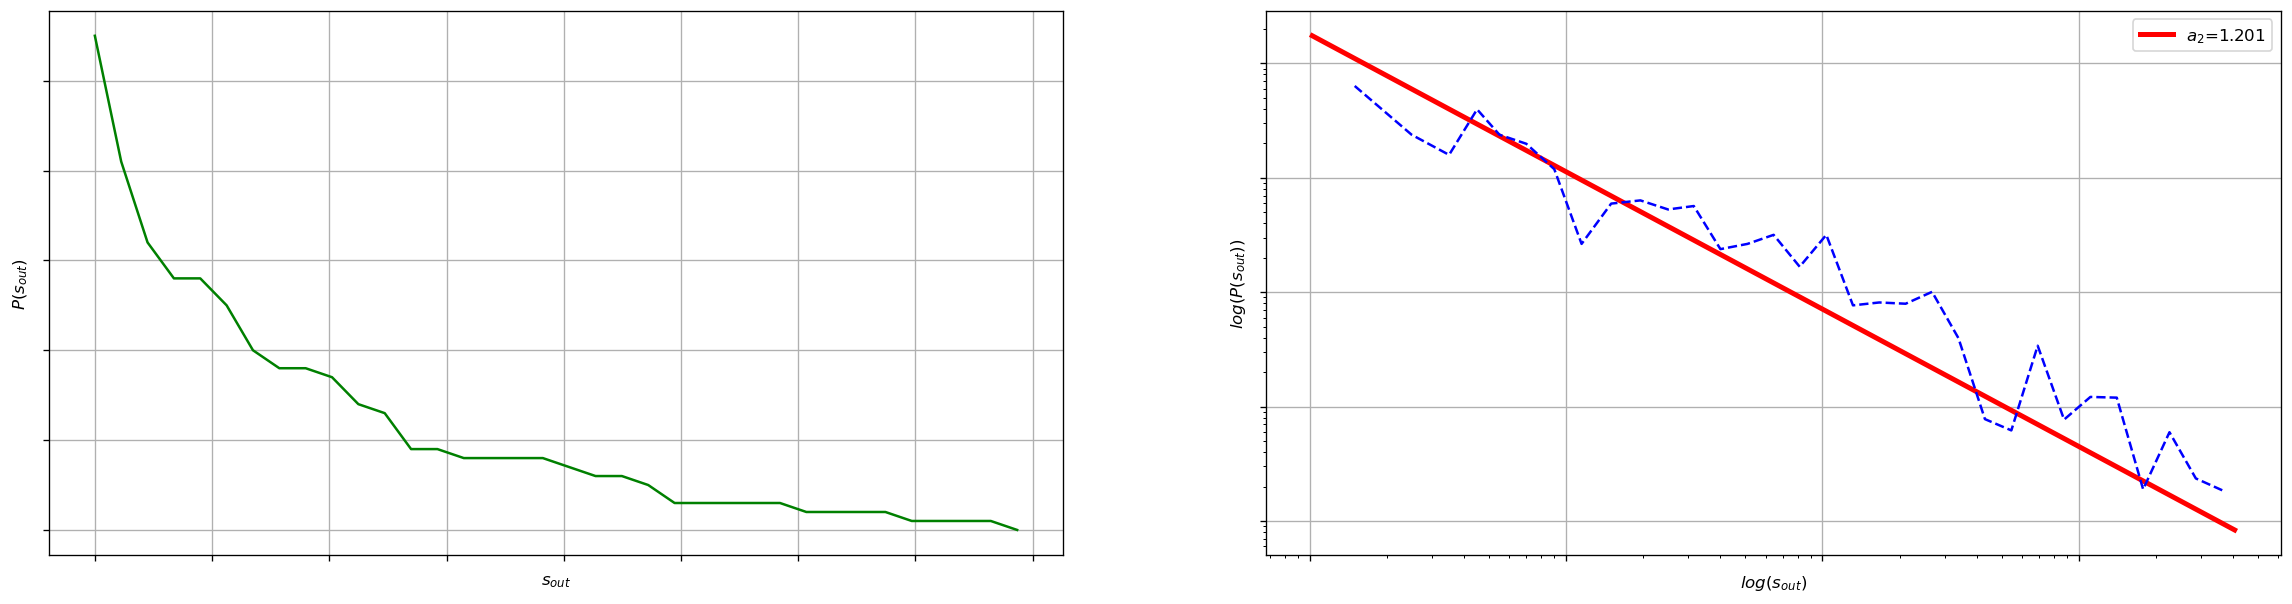

In [14]:
fig, axs = plt.subplots(1,2, figsize=(24,6), dpi=120)

values, base = np.histogram(k_in, bins=3*int(np.sqrt(len(k_in)))) # evaluate the histogram
cumulative = np.cumsum(values) #evaluate the cumulative

axs[0].plot(base[:-1], len(k_in)-cumulative, c='green')

axs[0].grid(True)
axs[0].set_xlabel('$s_{in}$')
axs[0].set_ylabel('$P(s_{in})$')
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])


results = pl.Fit(k_in, xmin=1, discrete=True)
results.power_law.plot_pdf(ax=axs[1], linewidth=3, color="r", label="$a_1$=${0}$".format(round(results.power_law.alpha,4)))
results.plot_pdf(ax=axs[1], linestyle="--", color="b")

axs[1].grid(True)
axs[1].set_xlabel('$log(s_{in})$')
axs[1].set_ylabel('$log(P(s_{in}))$')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])

plt.legend(loc="upper right")
plt.show()



fig, axs = plt.subplots(1,2, figsize=(24,6), dpi=120)

values, base = np.histogram(k_out, bins=3*int(np.sqrt(len(k_out)))) # evaluate the histogram
cumulative = np.cumsum(values) #evaluate the cumulative

axs[0].plot(base[:-1], len(k_out)-cumulative, c='green')

axs[0].grid(True)
axs[0].set_xlabel('$s_{out}$')
axs[0].set_ylabel('$P(s_{out})$')
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])


results = pl.Fit(k_out, xmin=1, discrete=True)
results.power_law.plot_pdf(ax=axs[1], linewidth=3, color="r", label="$a_2$=${0}$".format(round(results.power_law.alpha,4)))
results.plot_pdf(ax=axs[1], linestyle="--", color="b")

axs[1].grid(True)
axs[1].set_xlabel('$log(s_{out})$')
axs[1].set_ylabel('$log(P(s_{out}))$')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])

plt.legend(loc="upper right")
plt.show()

En ambos casos, $s_{in}$ y $s_{out}$, es posible distinguir una ley de potencia en su distribución conjunta. Además, ambas presentan coeficientes muy similares, con $1.2429$ y $1.201$ respectivamente.

### Sección d

El gráfico asociado a las distribuciones conjuntas de los grados de los nodos es:

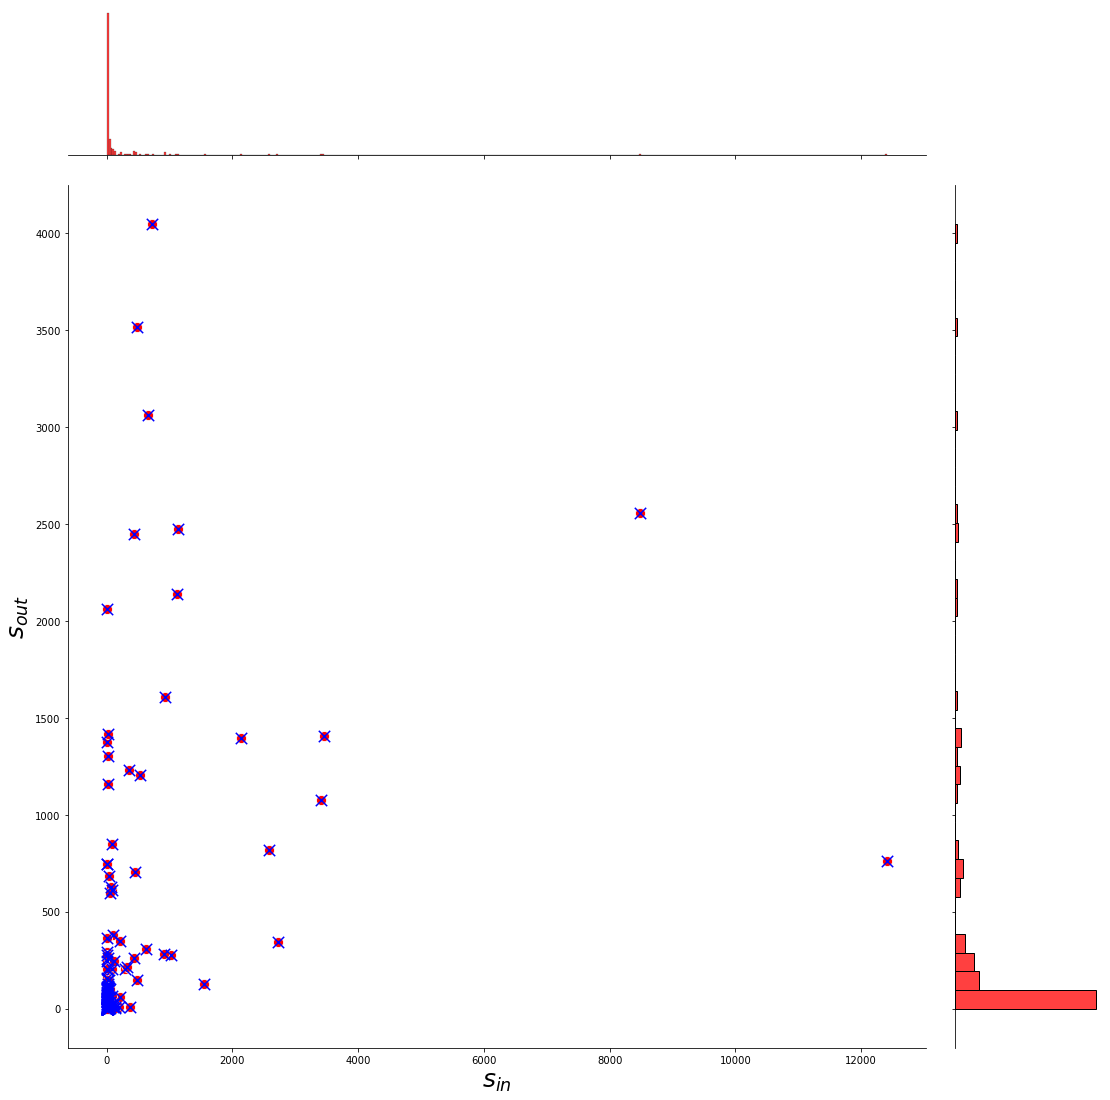

In [15]:
graph = sns.jointplot(x=k_in, y=k_out, color='red', height=15, s=100)

graph.x = k_in
graph.y = k_out
graph.plot_joint(plt.scatter, marker='x', c='blue', s=130)

graph.ax_joint.set_xlabel('$s_{in}$', fontsize=25)
graph.ax_joint.set_ylabel('$s_{out}$', fontsize=25)

plt.show()

En primera instancia es posible ver una relación entre valores bajos de importaciones y exportaciones para la mayoría de los nodos, particularmente en los valores de $[0,2000] \times [0,500]$. Este fenómeno se podría entender como una distribución homogénea del mercado de exportaciones de pescado (ósea no hay posibles monopolios).

## Parte 2

Partimos copiando los nodos del grafo original en un grafo no-direccional y conectamos los respectivos arcos y pesos actualizados:

In [16]:
pescado_limpio = nx.Graph()
pescado_limpio.add_nodes_from(pescado_g)

for edge in pescado_g.edges():
    node = edge[0]
    
    l_weights_in = [pescado_g.get_edge_data(*e)[0]['weight'] for e in pescado_g.in_edges(node)]
    l_weights_out = [pescado_g.get_edge_data(*e)[0]['weight'] for e in pescado_g.out_edges(node)] 
    
    pescado_limpio.add_edge(*edge, weight=np.sum(l_weights_in)+np.sum(l_weights_out))

La nueva matriz de pesos asociada es:

In [17]:
W_limpio = nx.adjacency_matrix(pescado_limpio)

### Sección e

Comenzamos obteniendo la lista de valores para las variables $k$, $s$, y $w$:

In [18]:
degree_k = [i[1] for i in pescado_limpio.degree]

In [19]:
s_undirected = lambda i: np.sum([W_limpio[i,j] for j in range(0,n)])
k_undirected = [s_undirected(i) for i in range(0,n)]

In [20]:
w_undirected = W_limpio[np.triu_indices(W_limpio.shape[0], k = 1)]

Luego graficamos las respectivas distribuciones de probabilidad conjunta para $P(k)$, $P(s)$ y $P(s)$:

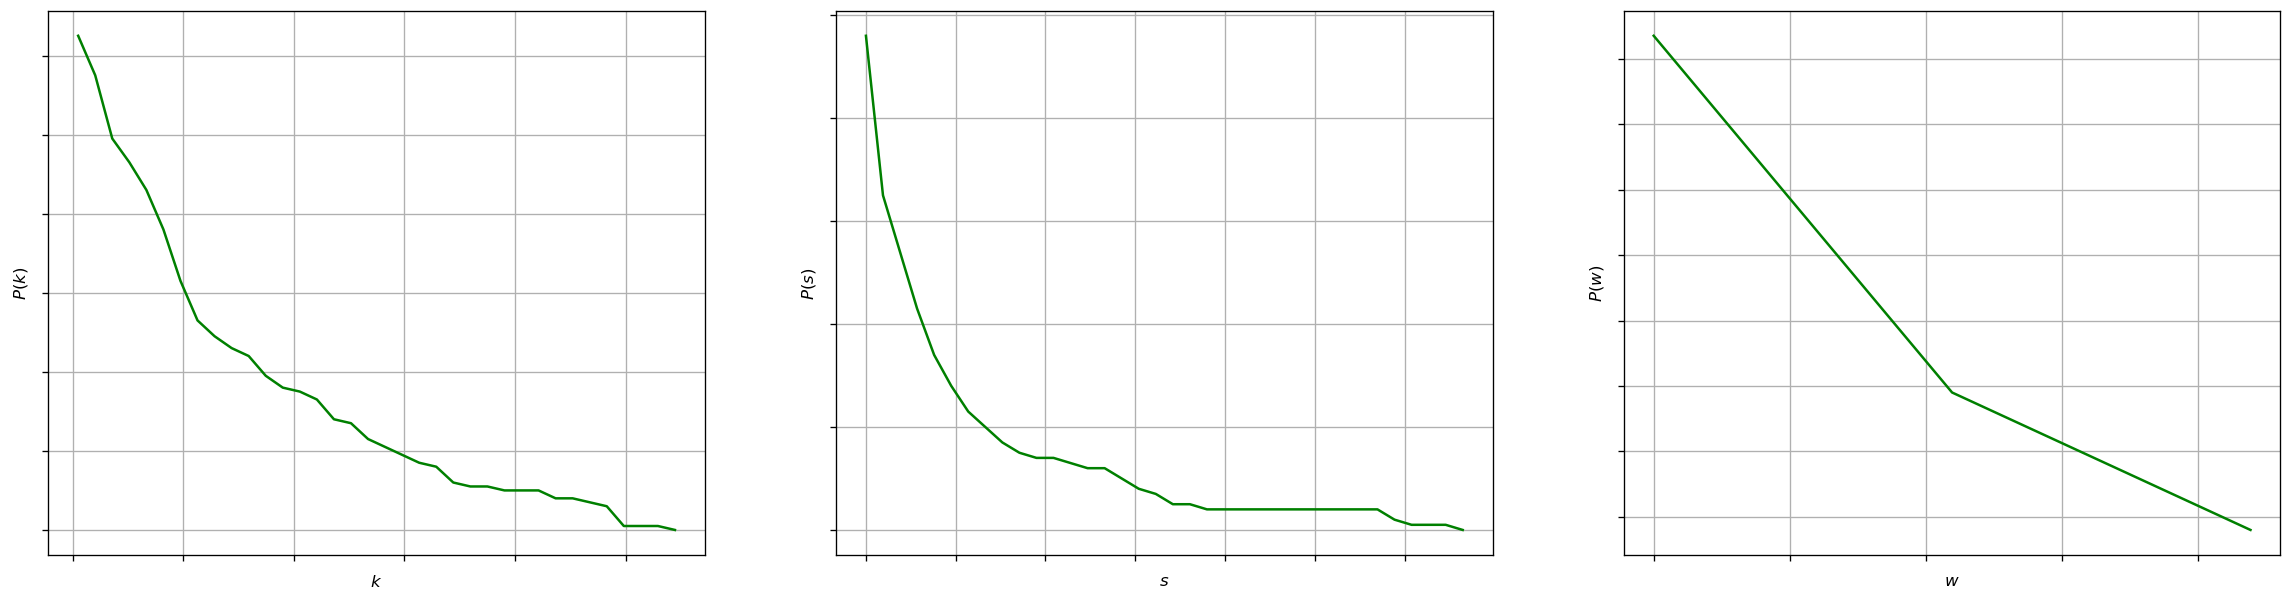

In [21]:
fig, axs = plt.subplots(1,3, figsize=(24,6), dpi=120)

## ------ P(k)
values, base = np.histogram(degree_k, bins=3*int(np.sqrt(len(degree_k)))) # evaluate the histogram
cumulative = np.cumsum(values) #evaluate the cumulative
axs[0].plot(base[:-1], len(degree_k)-cumulative, c='green')
axs[0].grid(True)
axs[0].set_xlabel('$k$')
axs[0].set_ylabel('$P(k)$')
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])

## ------ P(s)
values, base = np.histogram(k_undirected, bins=3*int(np.sqrt(len(k_undirected)))) # evaluate the histogram
cumulative = np.cumsum(values) #evaluate the cumulative
axs[1].plot(base[:-1], len(k_undirected)-cumulative, c='green')
axs[1].grid(True)
axs[1].set_xlabel('$s$')
axs[1].set_ylabel('$P(s)$')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])


## ------ P(w)
values, base = np.histogram(w_undirected, bins=3*int(np.sqrt(len(w_undirected)))) # evaluate the histogram
cumulative = np.cumsum(values) #evaluate the cumulative
axs[2].plot(base[:-1], len(w_undirected)-cumulative, c='green')
axs[2].grid(True)
axs[2].set_xlabel('$w$')
axs[2].set_ylabel('$P(w)$')
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])

plt.show()

Es interesante notar que, en los tres casos, sigue existiendo una ley de potencia en sus distribuciones, aun que en el caso de los $w$ la curva asociada es un poco menos detallada que las otras dos, pero sigue manteniendo una estructura similar. Luego, para los tres casos, calcularemos su respectivo coeficiente:

/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values


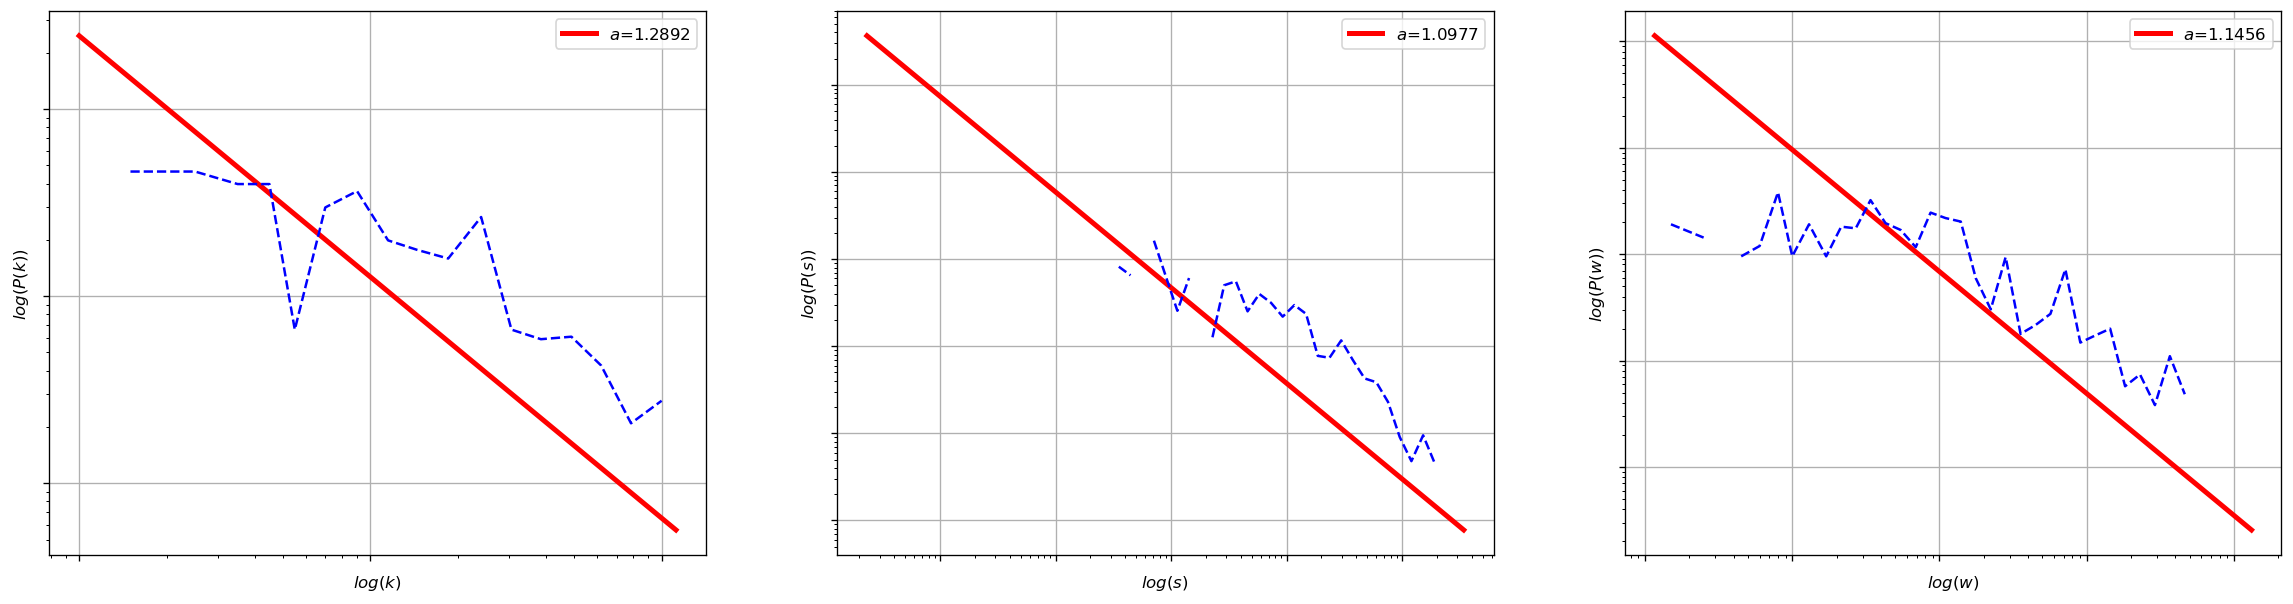

In [22]:
fig, axs = plt.subplots(1,3, figsize=(24,6), dpi=120)

## ------ P(k)
results = pl.Fit(degree_k, xmin=1, discrete=True)
results.power_law.plot_pdf(ax=axs[0], linewidth=3, color="r", label="$a$=${0}$".format(round(results.power_law.alpha,4)))
results.plot_pdf(ax=axs[0], linestyle="--", color="b")

axs[0].grid(True)
axs[0].set_xlabel('$log(k)$')
axs[0].set_ylabel('$log(P(k))$')
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].legend(loc="upper right")

## ------ P(s)
results = pl.Fit(k_undirected, xmin=1, discrete=True)
results.power_law.plot_pdf(ax=axs[1], linewidth=3, color="r", label="$a$=${0}$".format(round(results.power_law.alpha,4)))
results.plot_pdf(ax=axs[1], linestyle="--", color="b")

axs[1].grid(True)
axs[1].set_xlabel('$log(s)$')
axs[1].set_ylabel('$log(P(s))$')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].legend(loc="upper right")

## ------ P(w)
results = pl.Fit(np.squeeze(np.asarray(w_undirected)), xmin=1, discrete=True)
results.power_law.plot_pdf(ax=axs[2], linewidth=3, color="r", label="$a$=${0}$".format(round(results.power_law.alpha,4)))
results.plot_pdf(ax=axs[2], linestyle="--", color="b")

axs[2].grid(True)
axs[2].set_xlabel('$log(w)$')
axs[2].set_ylabel('$log(P(w))$')
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])
axs[2].legend(loc="upper right")

plt.show()

Finalmente, los parámetros asociados a las destrucciones de $P(k)$, $P(s)$ y $P(s)$ encontradas, las cuales cumplen con ser una ley de potencia, son: $a_{k}=1.2892$, $a_{k}=1.0977$ y $a_{k}=1.1456$. Es importante notar que, para los primeros dos casos, la curva logarítmica de la ley se ajusta mucho mejor que la del ultimo grafico asociado a $P(w)$, por lo que podría existir el caso en que $w$ cumple con otra curva polinomial no asicada a la clásica ley de potencia.

### Sección f

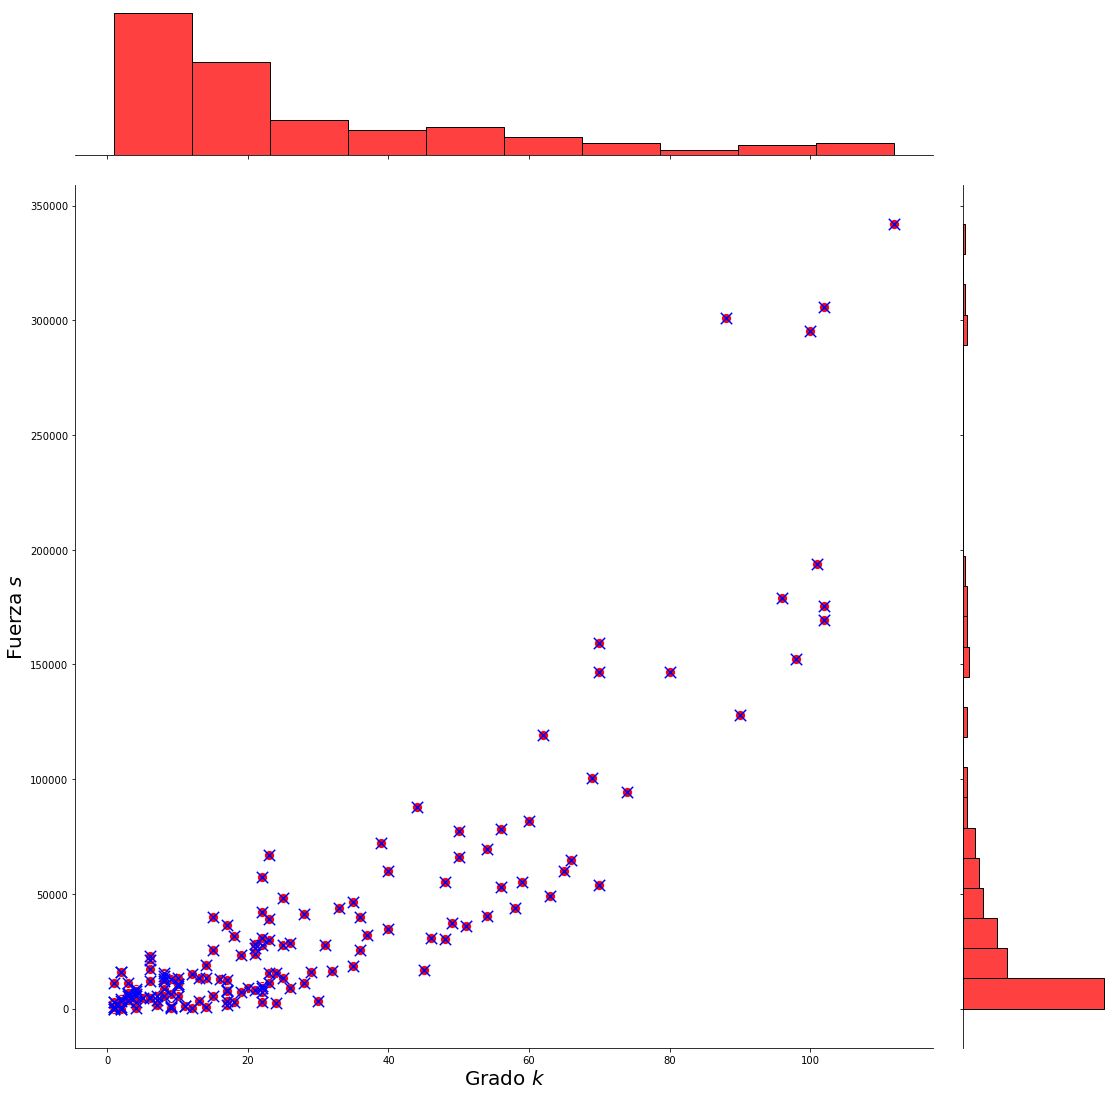

In [23]:
graph = sns.jointplot(x=degree_k, y=k_undirected, color='red', height=15, s=100)

graph.x = degree_k
graph.y = k_undirected
graph.plot_joint(plt.scatter, marker='x', c='blue', s=130)

graph.ax_joint.set_xlabel('Grado $k$', fontsize=20)
graph.ax_joint.set_ylabel('Fuerza $s$', fontsize=20)

plt.show()

Para este caso, sí es posible identificar una relación semi-lineal entre la fuerza de los grados de $s$ y los grados de los nodos, aun que la curva asociada al comportamiento tenga una descomposición polinomial mejor que una de primer orden. Sin embargo, si es posible notar una proporcionalidad en los datos de las variables.

### Sección g

Finalmente, el promedio del índice de clustering para la red sin y con pesos son respectivamente:

In [24]:
print(round(nx.average_clustering(pescado_limpio),5))
print(round(nx.average_clustering(pescado_limpio,weight='weight'),5))

0.74776
0.05485


En este caso, la red sin pesos tiene un promedio mucho mayor que la red con pesos. Para entender esto, es necesario considerar que a libreria utiliza la formula $C=\frac{1}{N} \sum C_{i}$_(Marcus Kaiser,2008)_ con $C_{i}=\frac{\Gamma_{i}}{\operatorname{deg}_{i}\left(\operatorname{deg}_{i}-1\right)}$ para calcular el coeficiente de una red sin pesos, mientras que utiliza una metrica mucho mas compleja $\widetilde{C}_{i}=\frac{\sum_{j, k} \hat{w}_{i j} \hat{w}_{j k} \hat{w}_{i k}}{\sum_{j \neq k} \hat{w}_{i j} \hat{w}_{i k}}$_(J. Saramaki et. al., 2007)_ para una red con pesos.

# Pregunta 3

In [16]:
import pandas as pd

In [17]:
cities = pd.read_csv('./data/cities.txt', sep ='\n', names = ['population'])

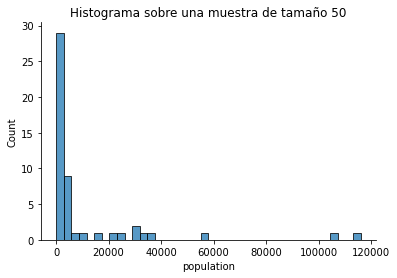

In [20]:
sns.histplot(cities.sample(50).population)
plt.title('Histograma sobre una muestra de tamaño 50')
sns.despine()

## loglog

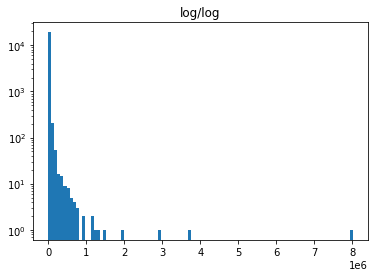

In [30]:
loglog_scale = pylab.hist(cities.population, bins = 100, log = True)
plt.title('log/log')
pylab.show()


<ipython-input-31-af838bb2921c>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(loglog_scale[0]), np.log10(loglog_scale[1][1:]))


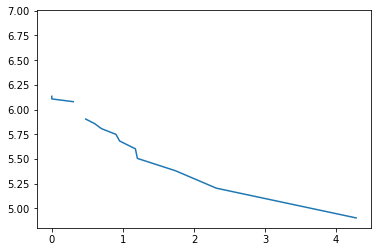

In [31]:
plt.plot(np.log10(loglog_scale[0]), np.log10(loglog_scale[1][1:]))

In [39]:
slope, intercept = np.polyfit(np.log10(loglog_scale[0]+1), np.log10(loglog_scale[1][1:]), 1)

In [40]:
print(f'Pendiente para log/log: {slope}')

Pendiente para log/log: -0.5609176988784639


## Binning Exponencial

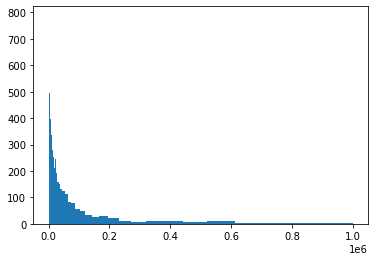

In [41]:
exp_binning = pylab.hist(cities.population, bins=np.logspace(np.log10(0.1),np.log10(1000000.0), 100))
#pylab.gca().set_xscale("log")
plt.title('')
pylab.show()

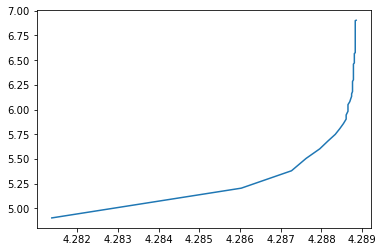

In [52]:
plt.plot(np.log10(exp_binning[0]), np.log10(exp_binning[1][1:]))

## Distribución cumulada

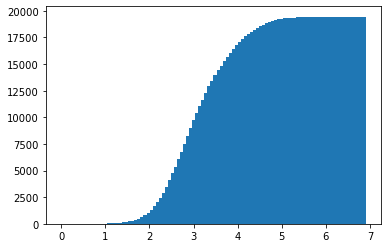

In [50]:
cumulative = pylab.hist(np.log10(cities.population), cumulative=True, bins = 100)


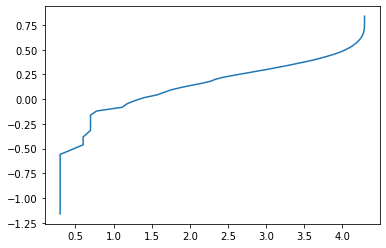

In [53]:
plt.plot(np.log10(cumulative[0]), np.log10(cumulative[1][1:]))

In [55]:
slope, intercept = np.polyfit(np.log10(cumulative[0]+1), np.log10(cumulative[1][1:]), 1)

In [56]:
print(f'Pendiente para acumulada: {slope}')

Pendiente para acumulada: 0.2971192774961081


# Pregunta 5

Generación de las redes sintéticas

In [2]:
er = nx.erdos_renyi_graph(10000, 4/10000, seed = SEED)
ba = nx.barabasi_albert_graph(10000, 2, seed = SEED)

In [3]:
print(f"Grado medio Red Erdos Renyi: {np.mean([x[1] for x in er.degree()])}")
print(f"Grado medio Red Barabasi Albert: {np.mean([x[1] for x in ba.degree()])}")

Grado medio Red Erdos Renyi: 4.001
Grado medio Red Barabasi Albert: 3.9992


## Erdös-Renyi

(discusión al final de los experimetnos de cada red)


### Estrategia $E_0$

In [37]:
%%time
er_e0_results = []
for seed in SEEDS:
    er_e0_results.append(simulate_infection(copy(er), 50, save_gif = False,
                                results_folder = './resultados/er', strategy = 'e0', plot_every = 10, seed = seed))

Wall time: 13min 43s


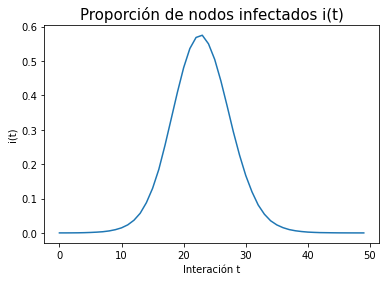

In [38]:
a = np.array(list(map(np.mean, 
                      [[x[i] for x in list(d['n_infected'] for d in er_e0_results)] for i in range(50)])))/len(er.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

### Estrategia $E_1$

In [8]:
%%time
er_e1_results = []
for seed in SEEDS:
    er_e1_results.append(simulate_infection(copy(er), 50, save_gif = False,
                                results_folder = './resultados/er', strategy = 'e1', plot_every = 5, seed = seed))

Wall time: 10min 48s


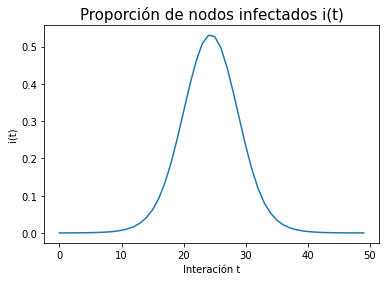

In [12]:
a = np.array(list(map(np.mean, [[x[i] for x in list(d['n_infected'] for d in er_e1_results)] for i in range(50)])))/len(er.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

### Estrategia $E_2$

In [10]:
%%time
er_e2_results = []
for seed in SEEDS:
    er_e2_results.append(simulate_infection(copy(er), 50, save_gif = False,
                                results_folder = './resultados/er', strategy = 'e2', plot_every = 5, seed = seed))

Wall time: 10min 49s


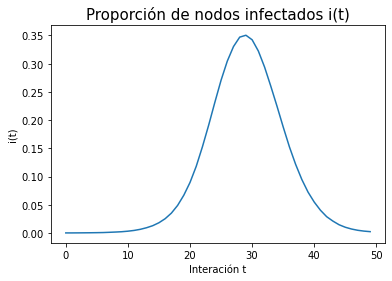

In [11]:
a = np.array(list(map(np.mean, 
                      [[x[i] for x in list(d['n_infected'] for d in er_e2_results)] for i in range(50)])))/len(er.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

### Estrategia $E_3$

In [4]:
%%time
er_e3_results = []
for seed in SEEDS:
    er_e3_results.append(simulate_infection(copy(er), 50, save_gif = False,
                                results_folder = './resultados/ba', strategy = 'e3', plot_every = 5, seed = seed))

Wall time: 12min 44s


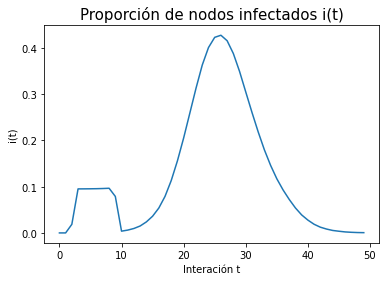

In [5]:
a = np.array(list(map(np.mean,
                      [[x[i] for x in list(d['n_infected'] for d in er_e3_results)] for i in range(50)])))/len(er.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

Se puede ver que para redes tipo Erdös-Renyi la estrategia a utilizar no implica diferencias significativas en lo que respecta a la aparente duración de la epidemia (unas 30 iteraciones aprox.), si cambia levemente la proporción de nodos infectados, siendo la estrategia que tienen como objetivo inmunizar nodos con alto grado primero las que muestran menor proporción de contagios incluso en los peaks. En el caso de la estrategia $E_2$ se puede ver no solo una menor proporción de nodos totales contagiados con respecto a las dos primeras estrategias, sino que además se observa un leve desplazamiento de la distribución, lo que podría sugerir que la epidemia tarda más en comenzar a propagarse en las primeras etapas. 

## Barabasi-Albert

### Estrategia $E_0$

In [6]:
%%time
ba_e0_results = []
for seed in SEEDS:
    ba_e0_results.append(simulate_infection(copy(ba), 50, save_gif = False,
                                results_folder = './resultados/ba', strategy = 'e0', plot_every = 5, seed = seed))

Wall time: 13min 26s


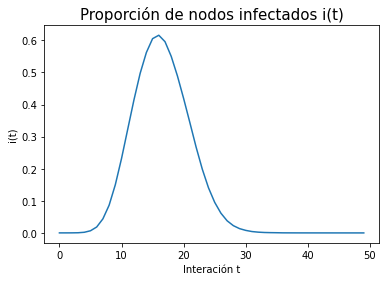

In [7]:
a = np.array(list(map(np.mean,
                      [[x[i] for x in list(d['n_infected'] for d in ba_e0_results)] for i in range(50)])))/len(ba.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

### Estrategia $E_1$

In [8]:
%%time
ba_e1_results = []
for seed in SEEDS:
    ba_e1_results.append(simulate_infection(copy(ba), 50, save_gif = False,
                                results_folder = './resultados/ba', strategy = 'e1', plot_every = 5, seed = seed))

Wall time: 10min 8s


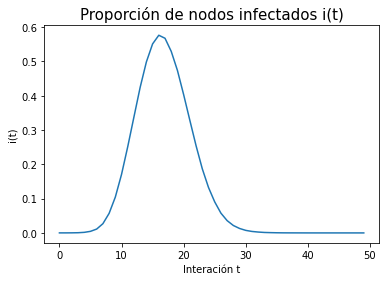

In [9]:
a = np.array(list(map(np.mean,
                      [[x[i] for x in list(d['n_infected'] for d in ba_e1_results)] for i in range(50)])))/len(ba.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

### Estrategia $E_2$

In [10]:
%%time
ba_e2_results = []
for seed in SEEDS:
    ba_e2_results.append(simulate_infection(copy(ba), 100, save_gif = False,
                                results_folder = './resultados/ba', strategy = 'e2', plot_every = 5, seed = seed))

Wall time: 5min 57s


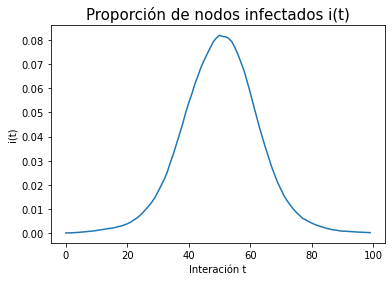

In [12]:
a = np.array(list(map(np.mean,
                      [[x[i] for x in list(d['n_infected'] for d in ba_e2_results)] for i in range(100)])))/len(ba.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

### Estrategia $E_3$

In [13]:
%%time
ba_e3_results = []
for seed in SEEDS:
    ba_e3_results.append(simulate_infection(copy(ba), 50, save_gif = False,
                                results_folder = './resultados/ba', strategy = 'e3', plot_every = 5, seed = seed))

Wall time: 17min 4s


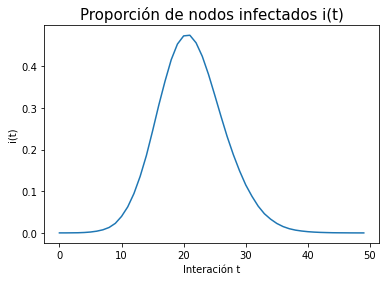

In [15]:
a = np.array(list(map(np.mean,
                     [[x[i] for x in list(d['n_infected'] for d in ba_e3_results)] for i in range(50)])))/len(ba.nodes())
plt.title('Proporción de nodos infectados i(t)', size = 15)
plt.xlabel('Interación t', fontsize = 10)
plt.ylabel('i(t)', fontsize = 10)
plt.plot(a);

En el caso de las redes tipo Barabasí-ALbert se puede notar una diferencia substancial en el desarrollo de la epidemia al utilizar distintas técnicas de inmunización. Interesantemente la vacunación al azar y la no vacunación presentan patronescasi idénticos visualmente, esto sugiere que en redes con conexiones preferenciales y hubs la vacunación aleatoria es poco efectiva, por otro lado, la mejoría es clara cuando se emplea algún grado de jerarquización en el orden de vacunación, al tratar de aprovechar el grado de los vecinos y la paradoja de la amistad en la estrategia $E_3$ se peude observar que, aunque se logra disminuir la proporción de nodos infectados, no es tan efectivo como seleccionar directamente a aquellos nodos con alto grado y vacunarlos de inmediato, una razón para esto puede ser que la cantidad de vacunas disponibles para vacunar es muy pequeña en comparación con la cantidad de vecinos que tiene un nodo en promedio, de manera que estas son acabadas rápidamente en tan solo unos cuantos nodos seleccionados junto con su vecindario.
Notar, finalmente, que la estrategia de vacunar a aquellos nodos por su grado es por lejos la más efectiva, presentando una proporción de contagios de menos del $10%$, el problema de esta aproximación, sin embargo, es que conocer el grado de cada uno de los nodos en una red no siempre es factible en la realidad, mientras que la estrategia de vacunar "vecindarios" si lo es.